# Reading current covid-19 data from a github-repo and displaying it using pandas

In [1]:
import pandas as pd
%matplotlib inline

# The data source

In [2]:
source_file = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

In [3]:
df = pd.read_csv(source_file)

# Exploring the data

In [4]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,50,53,59,70,75,82,114,147,177
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,502,511,581,639,639,701,773,839,825,878
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,150,150,160,178,178,200,212,226,243,266
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,99,117,129,149,149,197,238,428,566,673


# Adjust the data shape into a timeseries DataFrame for easier visualization

In [5]:
df_base = df.groupby('Country/Region').agg('sum').drop('Lat	Long'.split(),axis=1).T
df_base.index = pd.to_datetime(df_base.index, infer_datetime_format=True)

# I am also interested in the progession of the total count

In [6]:
df_base['World'] = df_base.sum(axis=1)

In [7]:
df_base.tail()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,World
2020-03-13,7,33,26,1,1,31,8,2,200,504,...,5,2179,3,85,802,0,0,0,47,145193
2020-03-14,11,38,37,1,1,34,18,2,250,655,...,5,2727,3,85,1144,4,0,2,53,156097
2020-03-15,16,42,48,1,1,45,26,2,297,860,...,6,3499,3,98,1145,4,1,10,56,167449
2020-03-16,21,51,54,2,1,56,52,2,377,1018,...,18,4632,7,98,1551,8,6,17,61,181531
2020-03-17,22,55,60,39,1,68,78,3,452,1332,...,47,6421,14,98,1960,29,10,33,66,197146


# ... checking which countries I can actually visualize

In [8]:
df_base.columns

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Antigua and Barbuda',
       'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria',
       ...
       'Turkey', 'US', 'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'Uruguay', 'Uzbekistan', 'Venezuela', 'Vietnam', 'World'],
      dtype='object', name='Country/Region', length=153)

# Ok apparently almost all there are. So just pick the ones I am interested in. Feel free to manipulate.

In [9]:
requested_countries = 'Germany China US World Italy'.split()

# Also want to see the growthrate. Since I expect it to be spiky, lets apply a moving average but know that this will blur the figures and general course a little into the future.

In [10]:
averaging_window_size = 3
df_base_growthrate = df_base[requested_countries].pct_change().rolling(window=averaging_window_size).mean().apply(lambda x: 100*x)

# Actually generate the plots, resized them a bit for better visual inspection

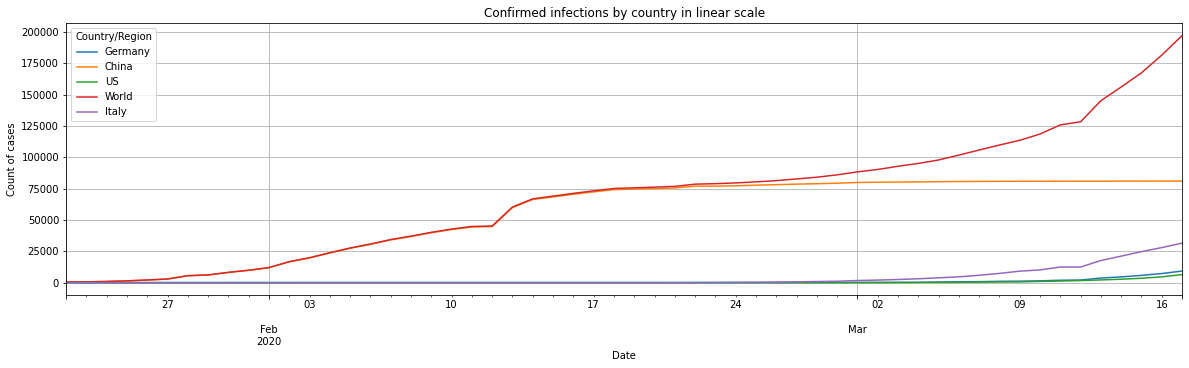

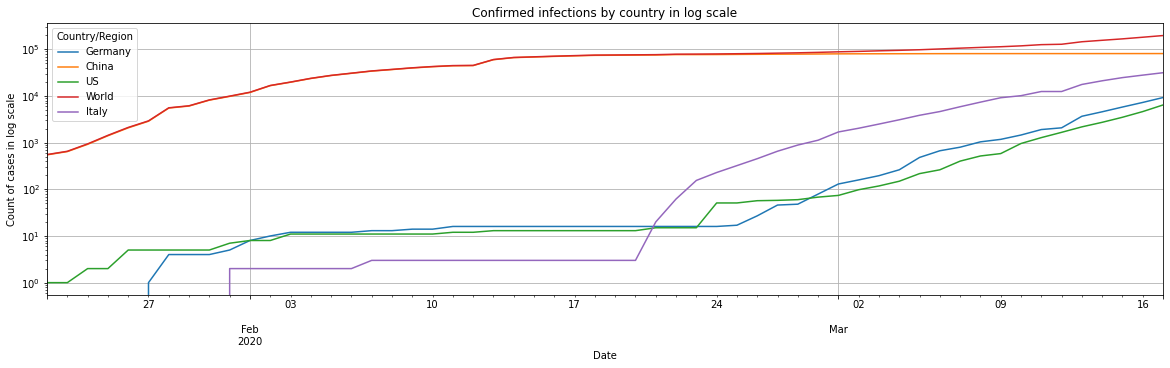

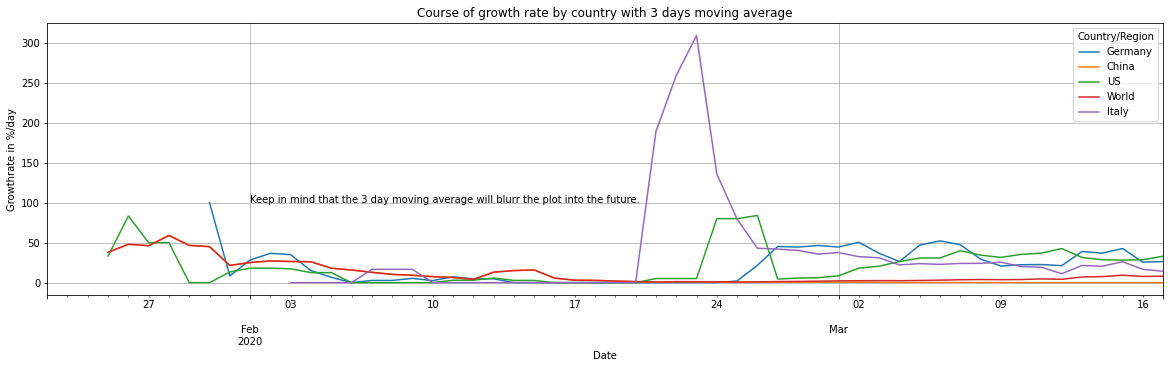

In [19]:
figure_size = (20,5)

ax0 = df_base[requested_countries].plot(grid=True,title='Confirmed infections by country in linear scale',figsize=figure_size)
ax0.set_xlabel('Date')
ax0.set_ylabel('Count of cases');

ax1 = df_base[requested_countries].plot(grid=True,logy=True,title='Confirmed infections by country in log scale',figsize=figure_size)
ax1.set_xlabel('Date')
ax1.set_ylabel('Count of cases in log scale');

ax2 = df_base_growthrate.plot(grid=True,title=f'Course of growth rate by country with {averaging_window_size} days moving average',figsize=figure_size)
ax2.set_xlabel('Date')
ax2.set_ylabel('Growthrate in %/day')
ax2.text('2020-02-01',100,f'Keep in mind that the {averaging_window_size} day moving average will blurr the plot into the future.');